In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
!pip install pgmpy
import pgmpy
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import accuracy_score


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore, TreeSearch
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
!pip install bnlearn
import bnlearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path_to_file = '/content/drive/My Drive/album_ratings.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.dropna(inplace=True)
source_df.reset_index(inplace=True, drop=True)
del source_df["Artist"]
del source_df["Title"]
del source_df["Label"]
del source_df["Genre"]

source_df

,Release Month,Release Day,Release Year,Format,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,March,3,2009,LP,79.0,31.0,8.7,31.0,79,25,78,55
1,February,17,2009,LP,70.0,14.0,8.4,7.0,73,11,73,8
2,January,20,2009,LP,89.0,36.0,8.5,619.0,92,30,87,1335
3,January,27,2009,LP,72.0,29.0,7.9,101.0,70,23,66,38
4,January,20,2009,LP,79.0,29.0,8.7,47.0,74,24,78,44
...,...,...,...,...,...,...,...,...,...,...,...,...
7937,October,13,2017,LP,81.0,6.0,5.6,29.0,80,4,76,4
7938,May,12,2012,LP,81.0,6.0,8.8,4.0,75,2,70,1
7939,June,25,2013,LP,73.0,5.0,8.4,7.0,74,4,71,2
7940,September,24,2002,LP,60.0,10.0,7.0,4.0,70,2,90,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
import sklearn
def code_categories(data: pd.DataFrame, method: str, columns: list) -> (pd.DataFrame, dict):
  data = data.dropna()
  data.reset_index(inplace=True, drop=True)
  d_data = data.copy()
  encoder_dict = dict()
  if method == 'label':
    for column in columns:
      le = sklearn.preprocessing.LabelEncoder()
      d_data[column] = le.fit_transform(d_data[column].values)
      mapping = dict(zip(le.classes_, range(len(le.classes_))))
      encoder_dict[column] = mapping
  elif method == 'onehot':
    d_data = pd.get_dummies(d_data, columns=columns)
  return d_data, encoder_dict

<AxesSubplot:>

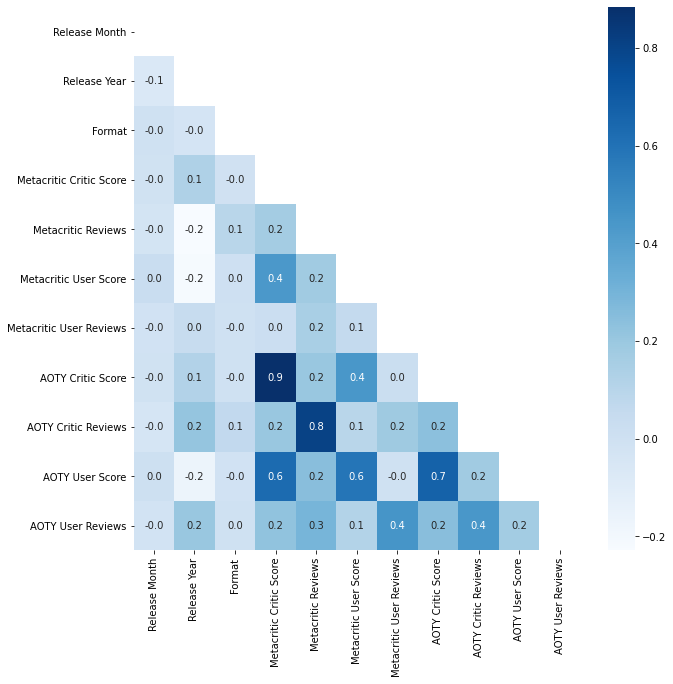

In [ ]:
# Building a correlation matrix of features
X = source_df
cat_params = ['Release Month', 'Format']
X, code_dict = code_categories(X, 'label', cat_params)

dataset = X
corr = dataset.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

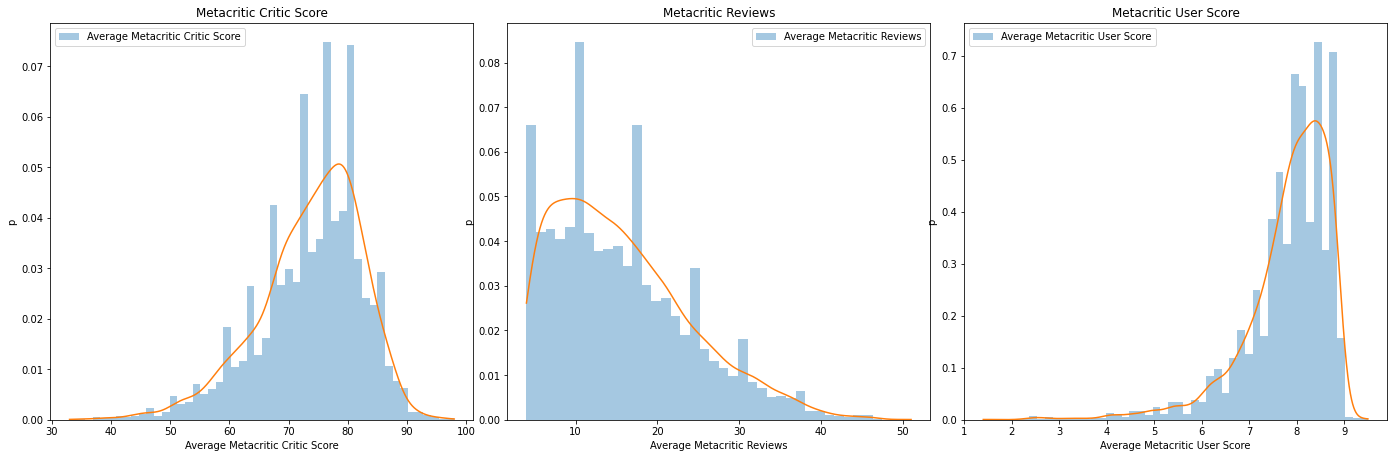

In [ ]:
# Target: Metacritic Critic Score, Metacritic Reviews,	Metacritic User Score
# Predicts: Rest without Genre

# Step 2: Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods

plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)

kernel = scipy.stats.gaussian_kde(source_df['Metacritic Critic Score'])

min_amount, max_amount = source_df['Metacritic Critic Score'].min(), source_df['Metacritic Critic Score'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values1 = kernel(x)

sns.distplot(source_df['Metacritic Critic Score'], kde=False, norm_hist=True, label=f'Average Metacritic Critic Score')
plt.title('Metacritic Critic Score')

plt.plot(x, kde_values1)

plt.ylabel('p')
plt.xlabel('Average Metacritic Critic Score')
plt.legend()
plt.tight_layout(pad=3.0)


plt.subplot(1, 3, 2)
kernel = scipy.stats.gaussian_kde(source_df['Metacritic Reviews'])

min_amount, max_amount = source_df['Metacritic Reviews'].min(), source_df['Metacritic Reviews'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values2 = kernel(x)

sns.distplot(source_df['Metacritic Reviews'], kde=False, norm_hist=True, label=f'Average Metacritic Reviews')
plt.title('Metacritic Reviews')
plt.plot(x, kde_values2)
plt.ylabel('p')
plt.xlabel('Average Metacritic Reviews')
plt.legend()


plt.subplot(1, 3, 3)
kernel = scipy.stats.gaussian_kde(source_df['Metacritic User Score'])

min_amount, max_amount = source_df['Metacritic User Score'].min(), source_df['Metacritic User Score'].max()
x = np.linspace(min_amount, max_amount, len(source_df))
kde_values3 = kernel(x)

sns.distplot(source_df['Metacritic User Score'], kde=False, norm_hist=True, label=f'Average Metacritic User Score')
plt.title('Metacritic User Score')
plt.plot(x, kde_values3)
plt.ylabel('p')
plt.xlabel('Average Metacritic User Score')
plt.legend()
plt.show()

In [ ]:
# Step 2: sampling
#inverse-transform sampling
def ITsampling(num_of_samples, data):
  u = np.random.uniform(size=num_of_samples)
  params = scipy.stats.lognorm.fit(data)
  samples = scipy.stats.lognorm.ppf(u, *params)
  return np.array(samples)

def plot_ITsamples(data, samples, title='Inverse Transform sampling'):
  plt.hist(samples, density=True, bins=int(1+3.32*np.log10(len(samples))), color='y', alpha = 0.5)
  plt.hist(data, density=True, bins=int(1+3.32*np.log10(len(data))), color='c', alpha = 0.3)
  plt.xlim(min(data), max(data))
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.lognorm.fit(data)
  f_vals = [scipy.stats.lognorm.pdf(x, *params) for x in x_vals]
  plt.plot(x_vals, f_vals, 'r', linewidth=2)
  plt.legend(['theoretical pdf', 'sampled data', 'initial data'])
  plt.title(title)
  plt.show()

# Accept-Reject sampling
#normal PDF
def norm_pdf(x, mu, sigma):
  return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

def search_M(data, mu, sigm):
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.norm.fit(data)
  f_vals = [scipy.stats.norm.pdf(x, *params) for x in x_vals]
  g_vals = norm_pdf(x_vals, mu, sigm)
  M = 1
  while np.where(g_vals*M < f_vals)[0].shape[0] > 0:
    M += 0.1
  plt.figure(figsize=(10,4))
  plt.plot(x_vals, f_vals)
  plt.plot(x_vals, M*g_vals)
  plt.xlabel('x', fontsize=20)
  plt.ylabel('Density', fontsize=20)
  plt.legend(['t(x)', 'S*h(x)'], fontsize=20)
  plt.title("M=%.2f"%M, fontsize=20)
  plt.show()
  return M

def AR_sampling(num_of_samples, data, mu, sigma, M):
  #collect all accepted samples here
  samples = []
  #try this many candidates
  for _ in range(num_of_samples):
    #sample a candidate
    candidate = np.random.normal(mu, sigma)
    #calculate probability of accepting this candidate
    params = scipy.stats.norm.fit(data)
    prob_accept = scipy.stats.norm.pdf(candidate, *params) / (M*norm_pdf(candidate, mu, sigma))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
      samples.append(candidate)
      # print("Num Samples Collected: %s"%len(samples))
      # print("Efficiency: %s"%round(len(samples) / num_of_samples, 3))
  return samples

def plot_ARsamples(data, samples, title='Accept-Reject sampling'):
  plt.figure(figsize=(10,4))
  plt.hist(samples, bins=200, density=True)
  plt.xlabel('x', fontsize=20)
  plt.xlabel('Density', fontsize=20)
  x_vals = np.unique(np.array(sorted(data)))
  params = scipy.stats.norm.fit(data)
  f_vals = [scipy.stats.norm.pdf(x, *params) for x in x_vals]
  plt.plot(x_vals, f_vals, linewidth=2)
  plt.xlim(min(data) - 1, max(data) + 1)
  plt.show()

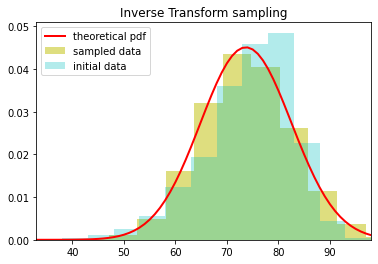

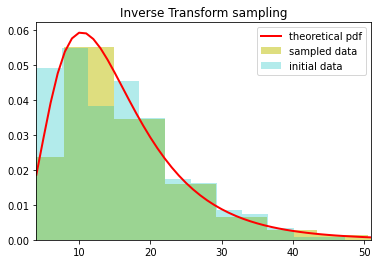

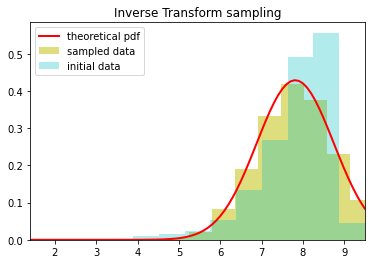

In [ ]:
# Inverse transform sampling of target variables
samples_data1 = ITsampling(7942, source_df['Metacritic Critic Score'])
plot_ITsamples(source_df['Metacritic Critic Score'], samples_data1, title='Inverse Transform sampling')

samples_data2 = ITsampling(7942, source_df['Metacritic Reviews'])
plot_ITsamples(source_df['Metacritic Reviews'], samples_data2, title='Inverse Transform sampling')

samples_data3 = ITsampling(7942, source_df['Metacritic User Score'])
plot_ITsamples(source_df['Metacritic User Score'], samples_data3, title='Inverse Transform sampling')

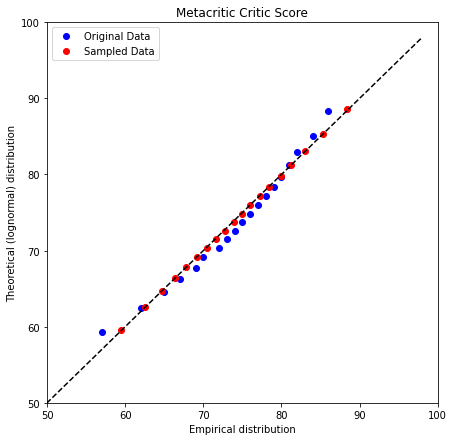

In [ ]:
# Analyse of quality of IT Samling: for Metacritic Critic Score

from math import sqrt

x1 = np.linspace(np.min(source_df['Metacritic Critic Score']), np.max(source_df['Metacritic Critic Score']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic Critic Score'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic Critic Score'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data1), np.max(samples_data1))
params2 = scipy.stats.lognorm.fit(samples_data1)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data1, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(50, 100)
plt.ylim(50, 100)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic Critic Score')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)

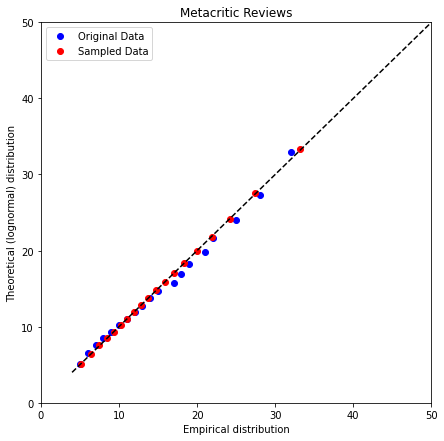

In [ ]:

# Analyse of quality of IT Samling: for Metacritic Reviews

x1 = np.linspace(np.min(source_df['Metacritic Reviews']), np.max(source_df['Metacritic Reviews']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic Reviews'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic Reviews'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data2), np.max(samples_data2))
params2 = scipy.stats.lognorm.fit(samples_data2)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data2, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic Reviews')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)


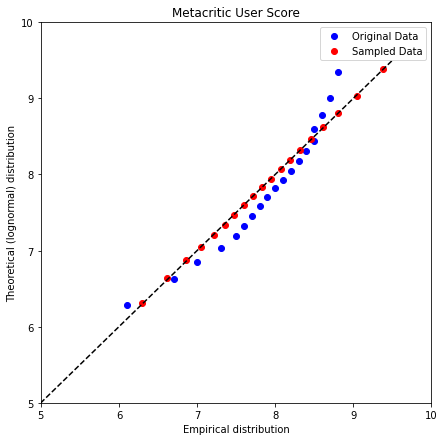

In [ ]:

x1 = np.linspace(np.min(source_df['Metacritic User Score']), np.max(source_df['Metacritic User Score']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic User Score'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic User Score'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data3), np.max(samples_data3))
params2 = scipy.stats.lognorm.fit(samples_data3)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data3, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(5, 10)
plt.ylim(5, 10)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic User Score')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)
plt.show()

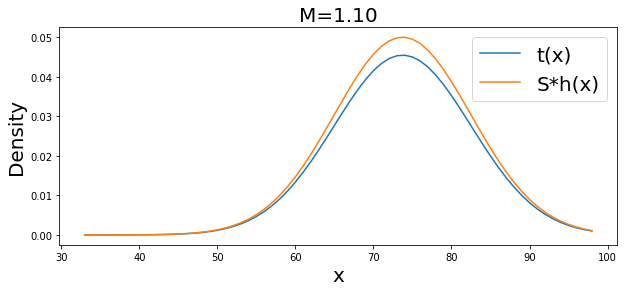

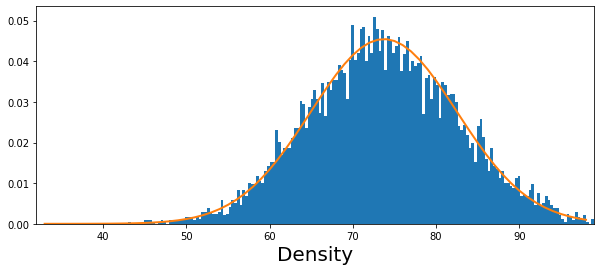

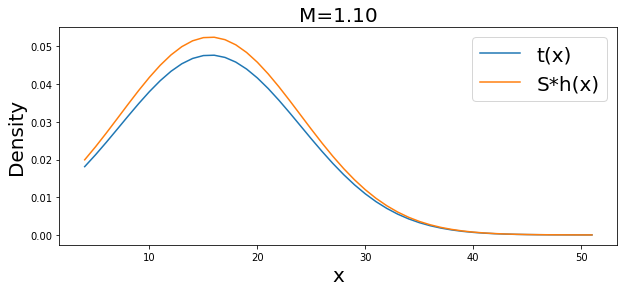

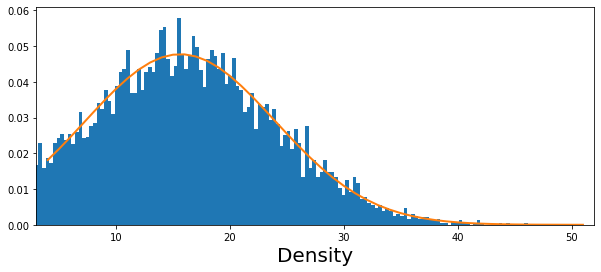

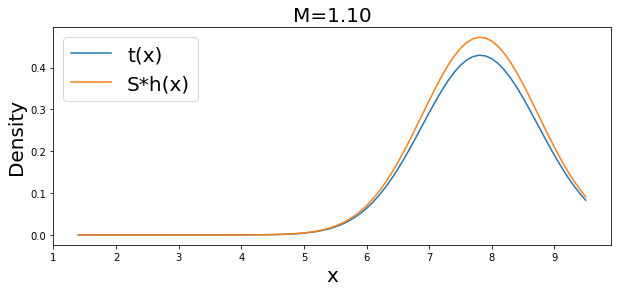

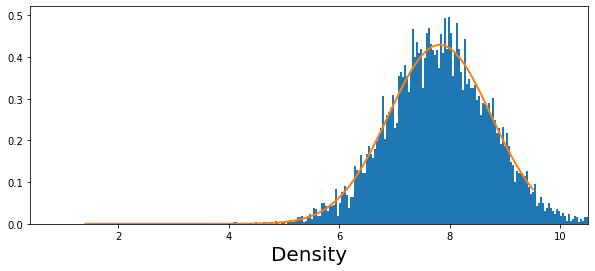

In [ ]:
# Accept-Reject sampling of chosen target variables
import math
M1 = search_M(source_df['Metacritic Critic Score'], np.mean(source_df['Metacritic Critic Score']), math.sqrt(np.var(source_df['Metacritic Critic Score'])))
samples_data1 = AR_sampling(7942, source_df['Metacritic Critic Score'],  np.mean(source_df['Metacritic Critic Score']), math.sqrt(np.var(source_df['Metacritic Critic Score'])), M1)
plot_ARsamples(source_df['Metacritic Critic Score'], samples_data1, title='Accept-Reject sampling')

M2 = search_M(source_df['Metacritic Reviews'],  np.mean(source_df['Metacritic Reviews']), math.sqrt(np.var(source_df['Metacritic Reviews'])))
samples_data2 = AR_sampling(7942, source_df['Metacritic Reviews'],  np.mean(source_df['Metacritic Reviews']), math.sqrt(np.var(source_df['Metacritic Reviews'])), M2)
plot_ARsamples(source_df['Metacritic Reviews'], samples_data2, title='Accept-Reject sampling')

M3 = search_M(source_df['Metacritic User Score'],  np.mean(source_df['Metacritic User Score']), math.sqrt(np.var(source_df['Metacritic User Score'])))
samples_data3 = AR_sampling(7942, source_df['Metacritic User Score'], np.mean(source_df['Metacritic User Score']), math.sqrt(np.var(source_df['Metacritic User Score'])), M3)
plot_ARsamples(source_df['Metacritic User Score'], samples_data3, title='Accept-Reject sampling')

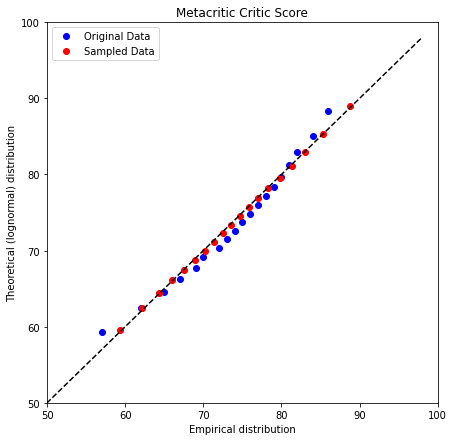

In [ ]:
# Analyse of quality of AR Samling: for Metacritic Critic Score

from math import sqrt

x1 = np.linspace(np.min(source_df['Metacritic Critic Score']), np.max(source_df['Metacritic Critic Score']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic Critic Score'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic Critic Score'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data1), np.max(samples_data1))
params2 = scipy.stats.lognorm.fit(samples_data1)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data1, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(50, 100)
plt.ylim(50, 100)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic Critic Score')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)

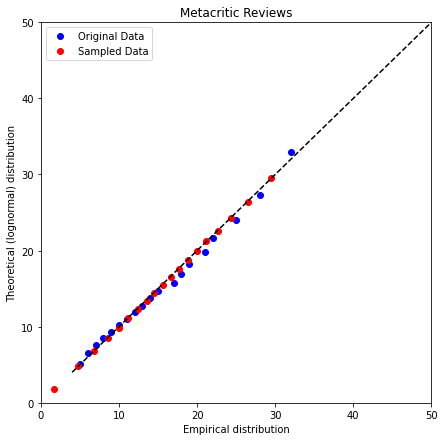

In [ ]:
# Analyse of quality of AR Samling: for Metacritic Reviews

x1 = np.linspace(np.min(source_df['Metacritic Reviews']), np.max(source_df['Metacritic Reviews']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic Reviews'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic Reviews'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data2), np.max(samples_data2))
params2 = scipy.stats.lognorm.fit(samples_data2)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data2, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic Reviews')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)


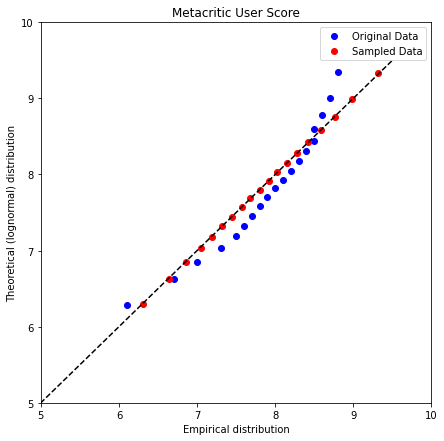

In [ ]:
x1 = np.linspace(np.min(source_df['Metacritic User Score']), np.max(source_df['Metacritic User Score']))
params1 = scipy.stats.lognorm.fit(source_df['Metacritic User Score'])
pdf1 = scipy.stats.lognorm.pdf(x1, *params1)

percs = np.linspace(0, 100, 21)
qn_first1 = np.percentile(source_df['Metacritic User Score'], percs)
qn_lognorm1 = scipy.stats.lognorm.ppf(percs / 100.0, *params1)

x2 = np.linspace(np.min(samples_data3), np.max(samples_data3))
params2 = scipy.stats.lognorm.fit(samples_data3)
pdf2 = scipy.stats.lognorm.pdf(x2, *params1)

qn_first2 = np.percentile(samples_data3, percs)
qn_lognorm2 = scipy.stats.lognorm.ppf(percs / 100.0, *params2)

# Building a quantile biplot
plt.figure(figsize=(7, 7))
plt.plot(qn_first1, qn_lognorm1, 'b', ls="", marker="o", markersize=6)
plt.plot(qn_first2, qn_lognorm2, 'r', ls="", marker="o", markersize=6)
plt.plot(x1, x1, color="k", ls="--")
plt.xlim(5, 10)
plt.ylim(5, 10)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')
plt.title('Metacritic User Score')
plt.legend(['Original Data', 'Sampled Data'], fontsize=10)
plt.show()

In [ ]:
# Step 4: Build a Bayesian network for chosen set of variables. Choose its structure on the basis 
# of multivariate analysis and train distributions in nodes using chosen algorithm
from sklearn import preprocessing

# Data Preprocessing 
# Target: Metacritic Critic Score, Metacritic Reviews,	Metacritic User Score
# Predicts: Rest without Genre

for column in ['Format','Release Month', 'Release Year']:
    le = preprocessing.LabelEncoder()
    source_df[column] = le.fit_transform(source_df[column].values)

source_df

,Release Month,Release Day,Release Year,Format,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,7,3,10,1,79.0,31.0,8.7,31.0,79,25,78,55
1,3,17,10,1,70.0,14.0,8.4,7.0,73,11,73,8
2,4,20,10,1,89.0,36.0,8.5,619.0,92,30,87,1335
3,4,27,10,1,72.0,29.0,7.9,101.0,70,23,66,38
4,4,20,10,1,79.0,29.0,8.7,47.0,74,24,78,44
...,...,...,...,...,...,...,...,...,...,...,...,...
7937,10,13,18,1,81.0,6.0,5.6,29.0,80,4,76,4
7938,8,12,13,1,81.0,6.0,8.8,4.0,75,2,70,1
7939,6,25,14,1,73.0,5.0,8.4,7.0,74,4,71,2
7940,11,24,3,1,60.0,10.0,7.0,4.0,70,2,90,1


In [73]:
transformed_data = copy(source_df)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(source_df.values[:,4:12])
transformed_data[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score', 'AOTY Critic Reviews', 'AOTY User Score', 'AOTY User Reviews']] = data_discrete
transformed_data

,Release Month,Release Day,Release Year,Format,Metacritic Critic Score,Metacritic Reviews,Metacritic User Score,Metacritic User Reviews,AOTY Critic Score,AOTY Critic Reviews,AOTY User Score,AOTY User Reviews
0,7,3,10,1,3.0,3.0,4.0,0.0,4.0,3.0,4.0,0.0
1,3,17,10,1,2.0,1.0,4.0,0.0,3.0,1.0,3.0,0.0
2,4,20,10,1,4.0,4.0,4.0,0.0,4.0,3.0,4.0,3.0
3,4,27,10,1,2.0,3.0,3.0,0.0,2.0,2.0,2.0,0.0
4,4,20,10,1,3.0,3.0,4.0,0.0,3.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7937,10,13,18,1,4.0,0.0,1.0,0.0,4.0,0.0,4.0,0.0
7938,8,12,13,1,4.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0
7939,6,25,14,1,3.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0
7940,11,24,3,1,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0


In [42]:
# Choose nodes based on previous multivariate analysis
targetlist = [('Metacritic Critic Score', 'AOTY Critic Score'), ('Metacritic Critic Score', 'AOTY User Score'), ('Metacritic Critic Score', 'Metacritic User Score'), 
              ('Metacritic Reviews', 'AOTY Critic Reviews'), ('Metacritic User Score', 'AOTY User Score'), ('Metacritic User Score', 'AOTY Critic Score'), 
              ('Metacritic User Reviews', 'AOTY User Reviews'), ('AOTY Critic Score', 'AOTY User Score'), ('AOTY Critic Reviews', 'AOTY User Reviews')]
targetlist

[('Metacritic Critic Score', 'AOTY Critic Score'),
 ('Metacritic Critic Score', 'AOTY User Score'),
 ('Metacritic Critic Score', 'Metacritic User Score'),
 ('Metacritic Reviews', 'AOTY Critic Reviews'),
 ('Metacritic User Score', 'AOTY User Score'),
 ('Metacritic User Score', 'AOTY Critic Score'),
 ('Metacritic User Reviews', 'AOTY User Reviews'),
 ('AOTY Critic Score', 'AOTY User Score'),
 ('AOTY Critic Reviews', 'AOTY User Reviews')]

In [45]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

Generating for node: AOTY User Score:   0%|          | 0/8 [00:00<?, ?it/s]  

True


Generating for node: AOTY User Score: 100%|██████████| 8/8 [00:00<00:00, 66.59it/s]


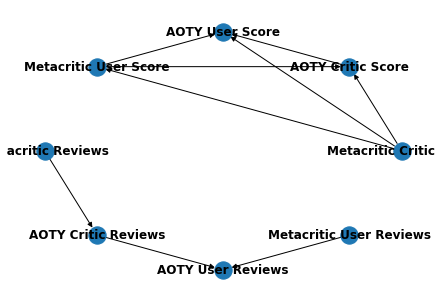

In [47]:
# Build a Bayesian network for chosen set of variables. Choose its structure on the basis multivariate analysis and train distributions in nodes using chosen algorithm.
network1 = BayesianModel(targetlist)

G = nx.DiGraph()
G.add_edges_from(network1.edges())
pos = nx.layout.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')

network1.fit(transformed_data)
print(network1.check_model())

# Use sampling
graph1 = sampling(network1, transformed_data, n=2000)

In [55]:
# Step 5: Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.
# 1 algorithm: HillClimbing, K2 Score func
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))
best_model_new = hc.estimate()

  0%|          | 17/1000000 [00:04<68:25:15,  4.06it/s]


Generating for node: Release Day: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


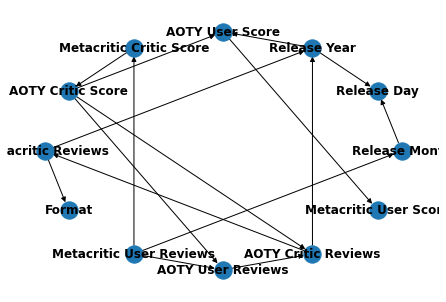

In [56]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_new.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

# Train dist in nodes
sample_hc = sampling(best_model_new, transformed_data, 46193)

In [57]:
# 2 structure learning algorithm - TreeSearch

ts = TreeSearch(transformed_data, root_node="Metacritic Critic Score")
best_model_2 = ts.estimate()

Building tree: 100%|██████████| 66/66.0 [00:00<00:00, 150.05it/s]


Generating for node: Release Month: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


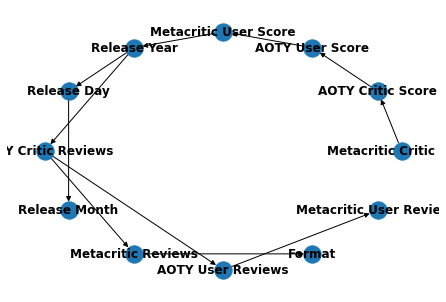

In [58]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_2.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

# Train dist in nodes
sample_ts = sampling(best_model_2, transformed_data, 46193)

In [59]:
# Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation)

sample_K2[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']] = est.inverse_transform(sample_K2[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']].values)
sample_ts[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']] = est.inverse_transform(sample_ts[['Metacritic Critic Score',	'Metacritic Reviews',	'Metacritic User Score',	'Metacritic User Reviews',	'AOTY Critic Score',	'AOTY Critic Reviews',	'AOTY User Score', 'AOTY User Reviews']].values)

In [60]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()			

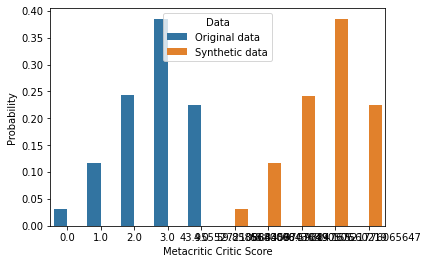

In [61]:
draw_comparative_hist('Metacritic Critic Score',transformed_data,sample_K2)

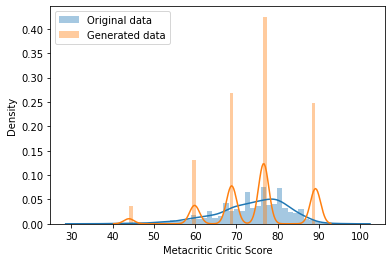

In [62]:
sns.distplot(source_df['Metacritic Critic Score'], label='Original data')
sns.distplot(sample_K2['Metacritic Critic Score'], label='Generated data')
plt.legend()

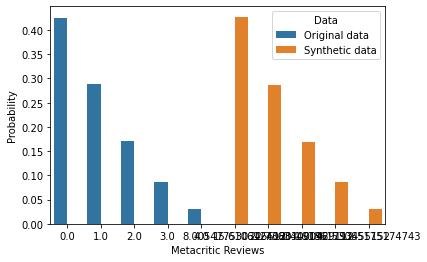

In [63]:
draw_comparative_hist('Metacritic Reviews',transformed_data,sample_K2)

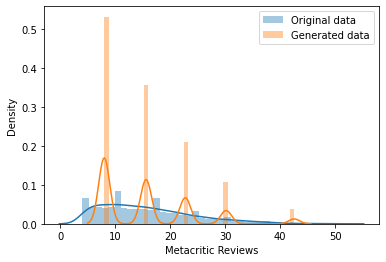

In [64]:
sns.distplot(source_df['Metacritic Reviews'], label='Original data')
sns.distplot(sample_K2['Metacritic Reviews'], label='Generated data')
plt.legend()

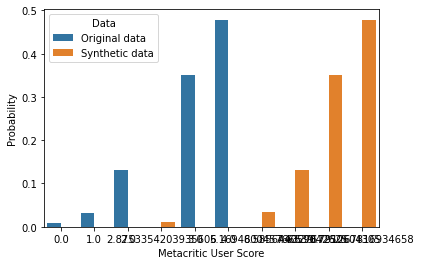

In [65]:
draw_comparative_hist('Metacritic User Score',transformed_data,sample_K2)

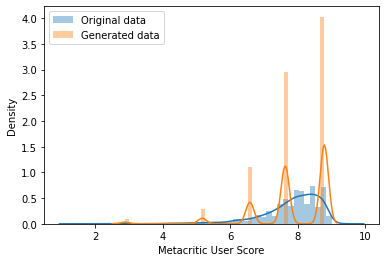

In [66]:
sns.distplot(source_df['Metacritic User Score'], label='Original data')
sns.distplot(sample_K2['Metacritic User Score'], label='Generated data')
plt.legend()

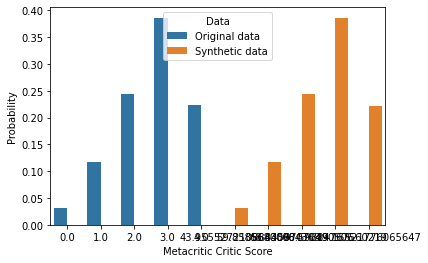

In [67]:
draw_comparative_hist('Metacritic Critic Score',transformed_data,sample_ts)

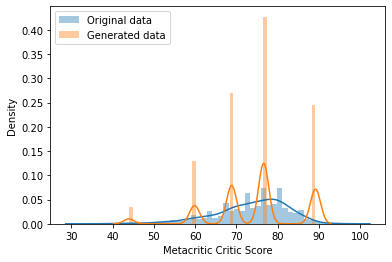

In [68]:
sns.distplot(source_df['Metacritic Critic Score'], label='Original data')
sns.distplot(sample_ts['Metacritic Critic Score'], label='Generated data')
plt.legend()

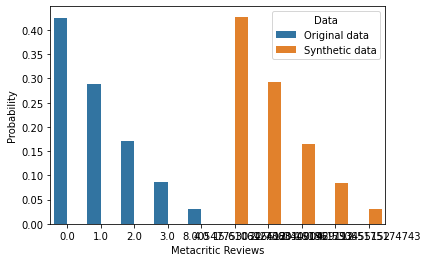

In [69]:
draw_comparative_hist('Metacritic Reviews',transformed_data,sample_ts)

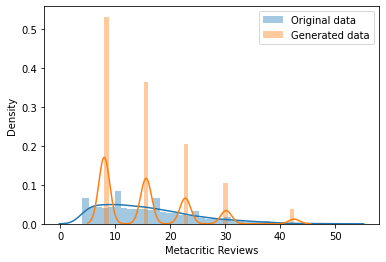

In [70]:
sns.distplot(source_df['Metacritic Reviews'], label='Original data')
sns.distplot(sample_ts['Metacritic Reviews'], label='Generated data')
plt.legend()

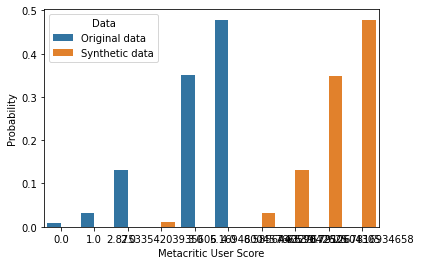

In [71]:
draw_comparative_hist('Metacritic User Score',transformed_data,sample_ts)

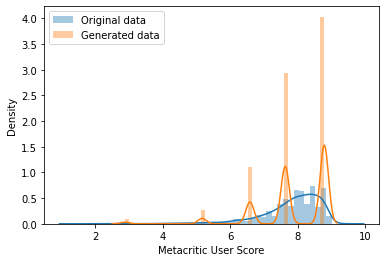

In [72]:
sns.distplot(source_df['Metacritic User Score'], label='Original data')
sns.distplot(sample_ts['Metacritic User Score'], label='Generated data')
plt.legend()

In [ ]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model_new.edges()), transformed_data)

In [ ]:
accuracy_k2